In [1]:
from PIL import Image, ImageDraw, ImageColor
from time import sleep
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
import copy

%matplotlib inline

In [2]:
# helper function
def box_size(box):
    left, top, right, down = box
    
    return right - left, down - top

def merge_boxes(box1, box2):
    l1, t1, r1, d1 = box1
    l2, t2, r2, d2 = box2
    
    left = min(l1, l2)
    top = min(t1, t2)
    right = max(r1, r2)
    down = max(d1, d2)
    
    return left, top, right, down

def is_another_in_between(box1, box2, boxes):
    l1, t1, r1, d1 = box1
    l2, t2, r2, d2 = box2
    
    # box1 is the one on top of box2, if its not the case, then flip them
    # TODO: this will not work if they are colliding or not in `top-down` position
    if t1 > t2:
        tmp = box1
        box1 = box2
        box2 = tmp
        
        l1, t1, r1, d1 = box1
        l2, t2, r2, d2 = box2
        
    for box in boxes:
        # ignore if its the same box
        if box == box1 or box == box2:
            continue
            
        left, top, right, down = box
        
        if d1 <= top <= t2:
            if ((left < r1 and right > l1) or (left < r2 and right > l2)):
                return True
    
    return False

In [3]:
def segment_char(img, start):
    """
    Runs given the image and where it should start,
    it will go recursively from the starting position and remove every
    black pixel until there is no more connected black pixels.
    
    Returns:
    - the image with the character containing `start` removed.
    - the box boundaries of the character
    """
    
    assert img.dtype == bool
    
    img = img.copy()
    h, w = img.shape
    
    left = right = start[0]
    top = down = start[1]
    
    queue = set([start])
    visited = set()
    
    while queue:
        now = queue.pop()
        
        # add to visited
        visited.add(now)
        
        # convert the pixel to white
        # Access in arrays is in `y, x` or `row, col` that's why it is inverted here
        img[now[1], now[0]] = True
        
        if now[0] > right:
            right = now[0]
        if now[0] < left:
            left = now[0]
        if now[1] > down:
            down = now[1]
        if now[1] < top:
            top = now[1]
        
        for i, j in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            x = now[0] + i
            y = now[1] + j

            # in bounds
            if 0 <= x < w and 0 <= y < h:
                # not visited
                if (x, y) not in visited:
                    # black
                    # Access in arrays is inverted
                    if not img[y, x]:
                        queue.add((x, y))
    
    return (left, top, right, down), img

# dot signs
def is_dot_box(box):
    w, h = box_size(box)
    return abs((w / h) - 1) < 0.2 or abs(w - h) < 2

# equal signs
def is_dash_box(box):
    w, h = box_size(box)
    return w / h > 4

def find_possible_equal_merges(crops):
    # 1- find all dash symbols
    dash_symbols = list(filter(is_dash_box, crops))
    
    def can_be_equal_sign(crop1, crop2):
        c1_w, c1_h = box_size(crop1)
        c1_size = c1_w * c1_h
        c2_w, c2_h = box_size(crop2)
        c2_size = c2_w * c2_h
        
        
        if abs(c1_w - c2_w) > 3:
            return False
        
        if abs(c1_size - c2_size) > 4:
            return False
        
        
        
        c1_left, c1_top, c1_right, c1_down = crop1
        c2_left, c2_top, c2_right, c2_down = crop2

        if c1_down >= c2_top:
            return False
        
        if abs(c1_left - c2_left) > 3:
            return False
        
        if is_another_in_between(crop1, crop2, crops):
            return False
        
        return True
    
    # 2- search through all of them and find the possible to merge
    return list(filter(lambda x: can_be_equal_sign(x[0], x[1]), permutations(dash_symbols, 2)))

def find_possible_colon_merges(crops):
    # 1- find all dot symbols
    dot_symbols = list(filter(is_dot_box, crops))
    
    def can_be_colon(crop1, crop2):
        c1_w, c1_h = box_size(crop1)
        c1_size = c1_w * c1_h
        c2_w, c2_h = box_size(crop2)
        c2_size = c2_w * c2_h
        
        if abs(c1_w - c2_w) > 3 or abs(c1_h - c2_h) > 3:
            return False
        
        c1_left, c1_top, c1_right, c1_down = crop1
        c2_left, c2_top, c2_right, c2_down = crop2

        if c1_down >= c2_top:
            return False
        
        if abs(c1_left - c2_left) > 3:
            return False
        
        if is_another_in_between(crop1, crop2, crops):
            return False
        
        return True
    
    # 2- search through all of them and find the possible to merge
    return list(filter(lambda x: can_be_colon(x[0], x[1]), permutations(dot_symbols, 2)))

def find_possible_i_j_merges(crops):
    # 1- find all dot symbols
    dot_symbols = list(filter(is_dot_box, crops))
    
    possible_combinations = []
    
    for dot_symbol in dot_symbols:
        for crop in crops:
            if crop not in dot_symbols:
                possible_combinations.append((dot_symbol, crop))
                
    def can_be_i_j(dot, crop):
        d_l, d_t, d_r, d_d = dot
        c_l, c_t, c_r, c_d = crop
        
        # dot must be on top
        if d_t > c_d or d_t > c_t:
            return False
        
        if d_l > c_r or d_r < c_l:
            return False
        
        w, h = box_size(crop)
        crop_size_ratio = w / h
        
        if abs(crop_size_ratio - 0.5) > 0.2:
            return False
        
        if is_another_in_between(dot, crop, crops):
            return False
        
        return True
    
    
    # 2- search through all characters with dots to find the merges
    return list(filter(lambda x: can_be_i_j(x[0], x[1]), possible_combinations))
    

def merge_segments(crops, possible_merges):
    if len(possible_merges) != 0:
        crops = copy.deepcopy(crops)
    
    for c1, c2 in possible_merges:
        if c1 in crops:
            crops.remove(c1)
        if c2 in crops:
            crops.remove(c2)
        
        crops.append(merge_boxes(c1, c2))
        
    return crops

def try_merge_segments(crops):
    # order is important
    crops = merge_segments(crops, find_possible_equal_merges(crops))
    crops = merge_segments(crops, find_possible_colon_merges(crops))
    crops = merge_segments(crops, find_possible_i_j_merges(crops))

    return crops
    

def get_all_segments(img: Image):
    """
    Segments the image into symbols.
    
    Returns an array of boxes that represent the boundaries of a single symbol
    """
    img_arr = np.array(img)
    h, w = img_arr.shape

    crops = []
    for x in range(w):
        for y in range(h):
            # Access in arrays is inverted because it is in form `row, col` == `y, x`
            if not img_arr[y, x]:
                (crop_box, img_arr) = segment_char(img_arr, (x, y))
                crops.append(crop_box)
    # tries to find symbols that are mergable, like `=`, `:`, `i`, `j`... and merge them
    crops = try_merge_segments(crops)
    return crops

In [4]:
def get_labeled_img(img):
    crops = get_all_segments(img)
    labeled_img = img.copy()
    labeled_img = labeled_img.convert('RGB')
    img_d = ImageDraw.Draw(labeled_img)
    
    for i, crop in enumerate(crops):
        img_d.rectangle(crop, outline=ImageColor.getrgb(f'hsl({i/len(crops)*360}, 100%, 50%)'))
        
    return labeled_img

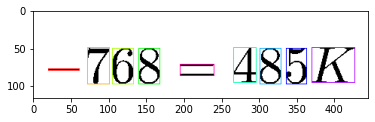

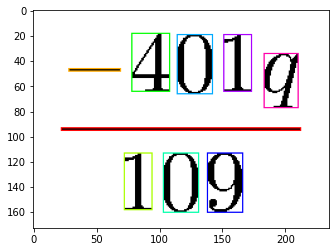

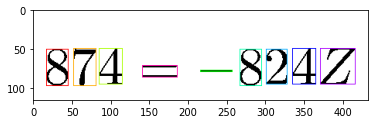

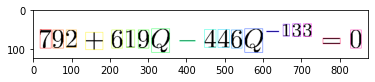

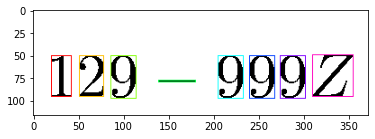

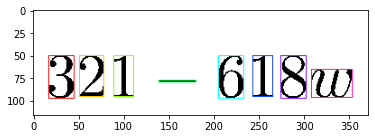

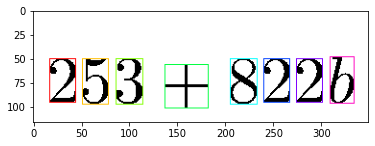

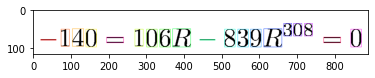

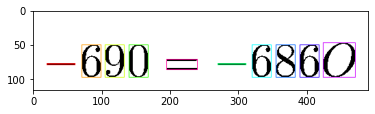

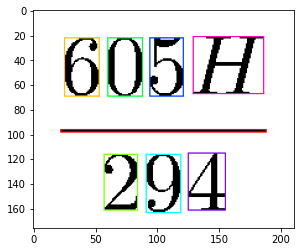

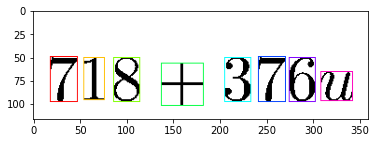

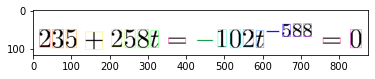

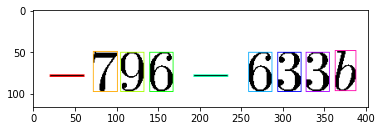

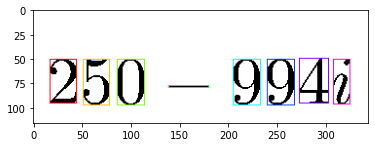

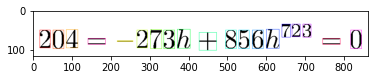

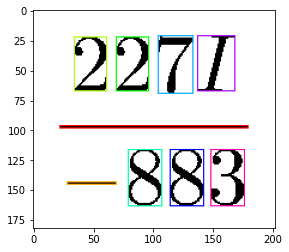

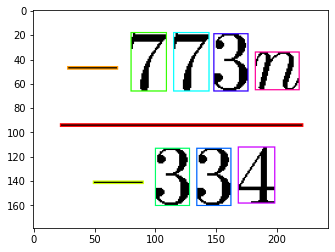

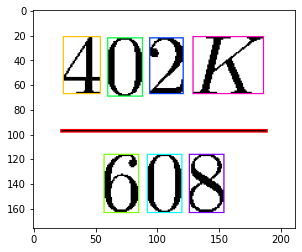

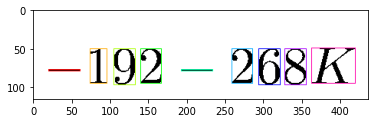

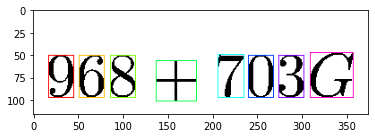

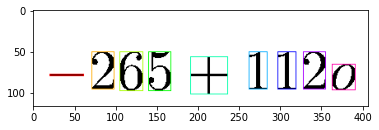

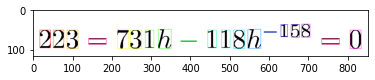

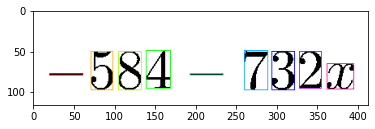

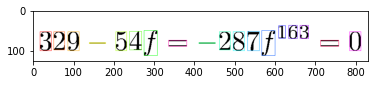

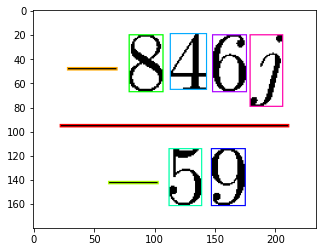

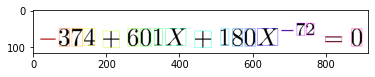

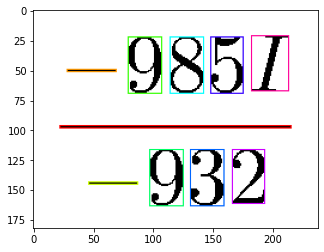

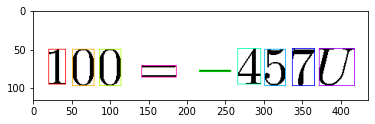

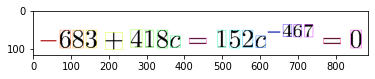

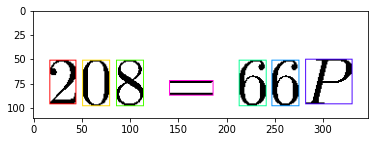

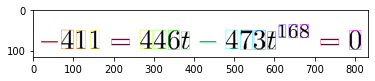

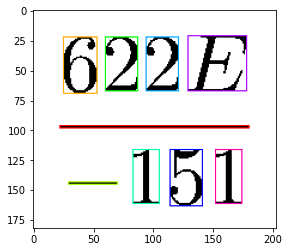

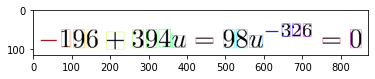

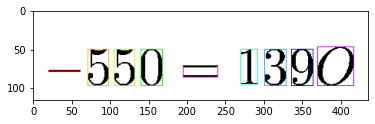

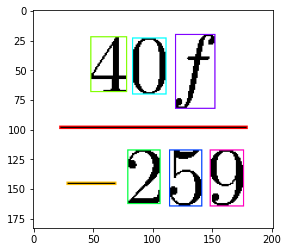

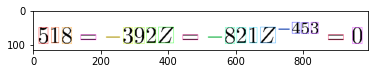

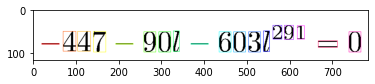

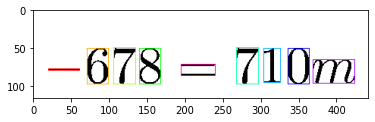

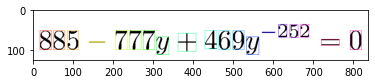

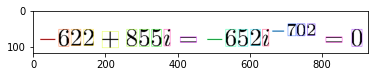

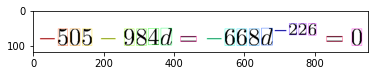

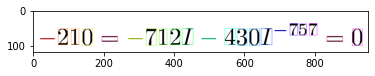

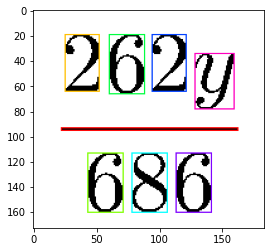

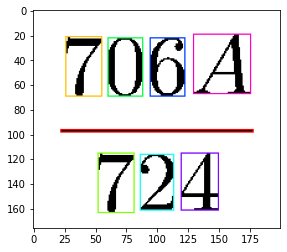

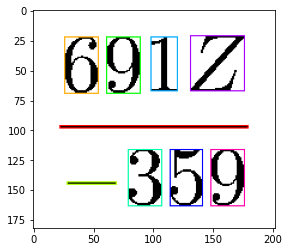

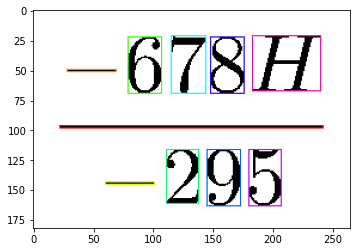

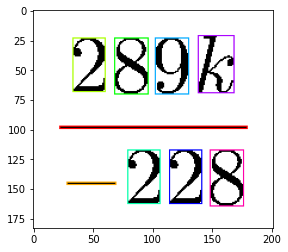

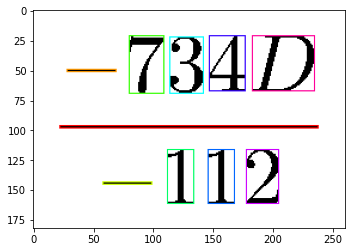

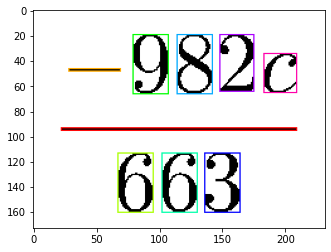

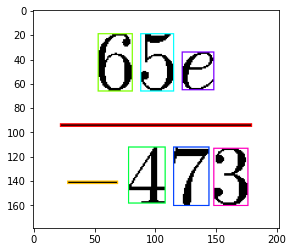

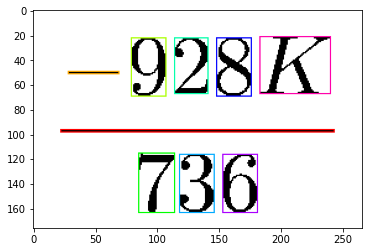

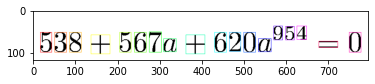

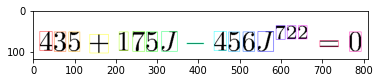

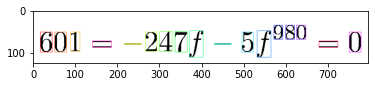

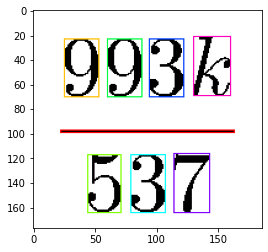

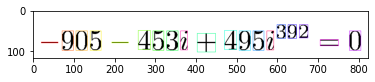

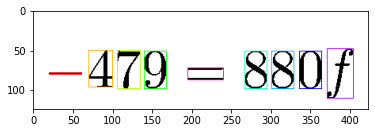

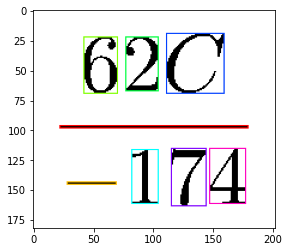

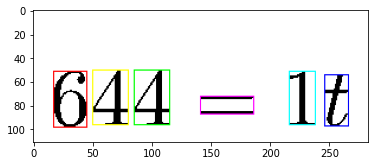

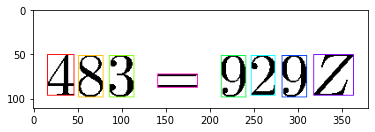

CPU times: user 7.17 s, sys: 194 ms, total: 7.37 s
Wall time: 7.37 s


In [5]:
%%time
for filename in glob('./dataset/*.png'):
    img = Image.open(filename)
    img = get_labeled_img(img)
    
    plt.figure()
    plt.imshow(img)
    plt.show()
